In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import inspect

In [3]:
torch.cuda.is_available()

True

## Transformer

This notebook will go through each module of the transformer architecture, using the paper [Attention is All You Need](https://arxiv.org/pdf/1706.03762) as reference.

![Transformer Architecture](images/architecture.png)

### Input Embeddings
The inputs to this layer are called **input IDs**. These IDs are the result of tokenizing the input text and representing each token as a number. This embeddings layer converts each input ID into a vector of dimensions `d_model`. 

We can do this using `nn.Embedding`.

In [4]:
inspect.signature(nn.Embedding)

<Signature (num_embeddings: int, embedding_dim: int, padding_idx: Optional[int] = None, max_norm: Optional[float] = None, norm_type: float = 2.0, scale_grad_by_freq: bool = False, sparse: bool = False, _weight: Optional[torch.Tensor] = None, _freeze: bool = False, device=None, dtype=None) -> None>

`nn.Embedding` is essentially a lookup table. For a vocabulary of size `num_embeddings`, it maps each ID to a vector of size `embedding_dim`. Here is an example:

In [5]:
tmp_embedding = nn.Embedding(5, 10)

`tmp_embedding` can convert a given input ID into a 10 dimensional vector. The first argument to `nn.Embedding` specifies that the ID can have upto 5 different values. (0 <= ID < 5).

Let us try to embed a few valid IDs.

In [6]:
tmp_x = torch.tensor([1, 2, 3])
tmp_y = tmp_embedding(tmp_x)
print(tmp_y)
print(f'\nInput shape: {tmp_x.shape}\nOutput shape: {tmp_y.shape}')

tensor([[ 1.1173, -1.0966,  1.5727, -0.3303, -1.5910, -1.8108,  1.0931, -0.3350,
          0.5483, -2.2271],
        [ 0.5462, -2.3664, -0.3480, -0.6978, -1.2902, -2.5477, -0.1921,  0.6393,
          1.1803,  2.3209],
        [-0.1043, -0.6807,  0.2425, -0.2927, -0.0865, -0.8930,  1.7562, -1.1676,
          0.0343,  1.7042]], grad_fn=<EmbeddingBackward0>)

Input shape: torch.Size([3])
Output shape: torch.Size([3, 10])


Here the input was a tensor with 3 different IDs, and the output was a 10d vector for each of the IDs, as a (3, 10) tensor. Now, since the `num_embeddings` argument was set to 5, it should fail for any IDs >= 5. Let us test that out.

In [7]:
try:
    tmp_x = torch.tensor([5])
    tmp_y = tmp_embedding(tmp_x)
except IndexError:
    print("index out of range")

index out of range


Now that we understand what the embedding layer does, let us build a class for the InputEmbeddings part of the transformer.

In [8]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.d_model = d_model # embeddings dimension
        self.vocab_size = vocab_size # num of items in vocabulary
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)

In the original paper, the embeddings have all their weights scaled by $\sqrt{d_{model}}$.

In [9]:
def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.embedding(x) * np.sqrt(self.d_model)

InputEmbeddings.forward = forward

Let us try to pass a 1d tensor and see if we get an output with expected shape. The expected output should be 10 embedding vectors, so the output should be `(10, d_model)`.

In [10]:
tmp_ie = InputEmbeddings(512, 1000)
tmp_e = tmp_ie(torch.arange(10))
tmp_e.shape

torch.Size([10, 512])

### Positional Encoding
In order for the model to understand that the order of the input sequence matters, we use positional encodings. We add sine and cosine values to the embeddings based on ther index in the sequence so that some information about their position is encoded in them.

The paper mentions:
$$
\begin{align}
PE(pos, 2i) &= \sin{(pos / 10000^\frac{2i}{d_{model}})} \\
PE(pos, 2i+1) &= \cos{(pos / 10000^\frac{2i}{d_{model}})}
\end{align}
$$

To simplify: `sin` for even indices and `cos` for odd indices.

We can use logarithms for better numerial stability.
$$
\begin{align}
&\log{(pos / 10000^\frac{2i}{d_{model}})} = \log{pos} - \frac{2i}{d_{model}} * \log{10000} \\
&pos / 10000^\frac{2i}{d_{model}} = pos * \exp{(-\frac{2i}{d_{model}} * \log{10000})}
\end{align}
$$

Here,  
$i$ is the index of values in an embedding (col index),  
and $pos$ is the position of each embedding in the entire sequnce (row index).

The positional encoding layer will recieve a 2d tensor of shape (`max_len`, `d_model`). Basically row 0 is the embedding vector for the 0th token, and so on. So, our positional encoding layer will have to generate a tensor of the same shape, and use the formulae above to populate it. 

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int) -> None:
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1)
        log_10000 = np.log(10000.0)

        div_term = torch.exp(-torch.arange(0, d_model, 2).float() * (log_10000 / d_model))
        encoding = position * div_term

        # dim1 here is batch_size. setting it to 1 so that broadcasting works with batches
        pe = torch.zeros(max_len, 1, d_model) 
        pe[:, 0, 0::2] = torch.sin(encoding)
        pe[:, 0, 1::2] = torch.cos(encoding)

        self.register_buffer('pe', pe)

To account for the fact that the input sequence might not be as long as `max_len`, we will clip the encodings till they match the shape needed.

In [12]:
def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = x + self.pe[:x.shape[0]]
    return x

PositionalEncoding.forward = forward

Let us try to visualize the encodings by using a null tensor.

In [13]:
tmp_max_len = 128
tmp_d_model = 128
tmp_PE = PositionalEncoding(tmp_d_model, tmp_max_len)
tmp_x = torch.zeros(100, tmp_d_model)
tmp_y = tmp_PE(tmp_x)

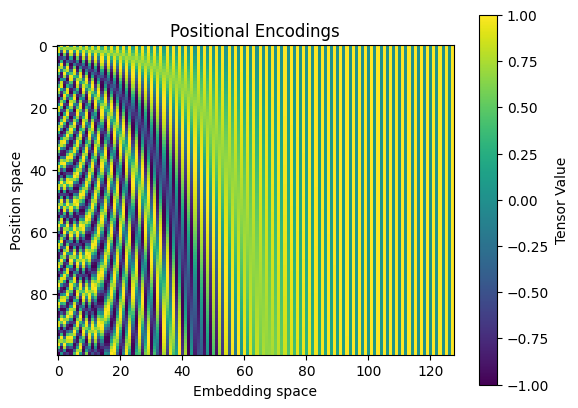

In [14]:
plt.title("Positional Encodings")
plt.xlabel("Embedding space")
plt.ylabel("Position space")
plt.imshow(tmp_y[:, 0, :], cmap='viridis')
plt.colorbar(label='Tensor Value')
plt.show()

### Feed Forward
The paper mentions a feed forward network with 1 hidden layer with $d_{ff} = 2048$ neurons. The input and output dimensions are $d_{model}$. ReLU activation is used everywhere.

In [15]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int = 2048) -> None:
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (batch_size, seq_len, d_model)
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return x

### Add & Norm
This part of the transformer implements layer normalization. This allows the inputs to be scaled and shifted. The parameters that are used to scale and shift by are also learnable. This stablizes the learning process by keeping the activations consistent between layers. 

We can make use of `nn.LayerNorm` from torch for this. We don't have to implement a seperate module for this.

### Multi-Head Attention

#### Attention
Let us first understand **Scaled dot product Attention**. The paper mentions this as:
$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

- Queries represent what each token in the sequnce is looking for. They're literally a "query".
- Keys represent a sort of "label" that tokens have. It tells other tokens what **kind of information** each token holds.
- Values represent the actual information that each token will contribute.

Thats their physical significance. Now let us look at how they're actually used, mathematically.

Each tensor (Q, K and V) is shaped `(seq_len, d_model)`.

Let us focus on the $QK^T$ part of attention.  
![QK^T](images/qk.svg)

So, what we've essentially done is take the dot product between each token's query with every token's key (including itself). This matrix ($QK^T$) now holds how much each token's query matches with all other token's values. It is a sort of *heatmap* that shows us how much tokens should be "attending" to each other. 
Meaning, $$QK^T[i, j] = \text{similarity between ith token's query and jth token's key}$$

Additionally, in the paper, they scale this matrix by $\sqrt{d_k}$. This is done to ensure that the variance of the dot products is brought back down to 1. This makes it much more stable for the softmax function.
Now, we have $\text{softmax}(\frac{QK^T}{\sqrt{d_k}})$ to work with. This is essentially the *heatmap* being converted into a probability distribution.
$$\text{softmax}(\frac{QK^T}{\sqrt{d_k}})[i, j] = \text{how much the ith token ``cares" about the jth token}$$

Here is the most important takeaway:
**The output of this softmax, is matrix that tells us how much each token cares about any other token.**

Now, coming to the value tensor: it holds the actual information. If query held the question, and key held the label, then value holds the actual information. We would want each token to absorb information from all other tokens, proportional to how much it "cares" about them. Luckily we have the tensors for that:
1. $\text{softmax}(\frac{QK^T}{\sqrt{d_k}})$ is a tensor telling us how much each token cares about any other token `(seq_len, seq_len)`
2. $V$ is a tensor telling us the information held by each token `(seq_len, d_model)`

If we matrix multiply these two, we get a new tensor where every row contains a token's "absorbed" information from every other token in the sequence, proportional to how much it cared about them.

**So, what was the point of doing all this?**
Well, when we started out we have an input embedding matrix. Any word from this input sequence, say 'bank', would have had the same embedding values regardless of whether it was part of a river bank or a banking institution.  What we did, was rephrase the entire matrix, into a more context aware one. Now, the embedding values for a 'bank' would be different if it was from a river or a financial context. This happened because the token